# Recommendation Systems Assignment

### MIE451/1513 UofT

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [1]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=292765d9ff30634dcc9bb64f628474ef58745edacb16a6d21f7d5f51569f4b01
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


## Support functions and variables

In [2]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [3]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [0]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [0]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [6]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
rating_df.shape

(100000, 4)

In [8]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


## Q1

### (a)

In [0]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########


    matrix = np.zeros((num_users,num_items),dtype=np.int8)
    
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating

    ###########         end         ###########
    return matrix

In [10]:
dataPreprocessor(rating_df, num_users, num_items).shape
## user is rows, and items is columns

(943, 1682)

In [45]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

### (b)

In [0]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros

        for (user,item), rating in np.ndenumerate(train_matrix):
          #(user,item) 2D-index
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
          if rating == 0:
              # select the row for user
              # what's the shape of userVector
              userVector = train_matrix[user, :]
              
              # Extract the items the user already rated
              ratedItems = userVector[userVector.nonzero()]
              
              # If not empty, calculate average and set as rating for the current item
              if ratedItems.size == 0:
                  itemAvg = 0
              else:
                  itemAvg = ratedItems.mean()
              predictionMatrix[user, item] = itemAvg
              
          # # report progress every 100 users
          # if (user % 100 == 0 and item == 1):
          #     print ("calculated %d users" % (user,))


        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array. from preprocessor
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        # Initialize the predicted rating matrix with zeros
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
        # popularity assume obove 4, is like
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated
        
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                predictionMatrix[user, item] = itemPopularity[item]
                
              
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [0]:
popularity_recsys = BaseLineRecSys('popularity')

In [0]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
x = popularity_recsys.getModel()

In [15]:
np.all(x<=1)

True

In [16]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [17]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:33, 1075.20it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


In [0]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [0]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

In [20]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.61029412, 3.61029412,
        3.61029412],
       [0.        , 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [21]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:31, 1087.90it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


## Q2

### (a)

In [0]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity cosine 1-->0 
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########
        # zero is the best similarity 
        
        similarity_matrix = pairwise_distances(matrix, metric='euclidean')
        similarity_matrix = 1/(1+similarity_matrix)
     
    
        ###########         end         ###########    
        
        return similarity_matrix
    # decorator
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
    
        similarity_matrix = 1/(1+pairwise_distances(matrix, metric="manhattan"))
    
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        # return userid, itemid rating
        #(943, 1682)
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########
            temp_matrix = np.zeros(train_matrix.shape)
            # Define function for converting 1-5 rating to 0/1 (like / don't like) or we cannot show if the user like or dislike
            # non zero position change to zero
            temp_matrix[train_matrix.nonzero()] = 1
            # method function(matrix)
            #(934,934) size 
            uu_similarity = self.method(train_matrix)
            # set missing value =0, known user and id=1, then uu similarity 
            # arguments are 2-D they are multiplied like conventional matrices
            #(usersRatings*usersSim).sum() / usersSim.sum()
            ## If there no users that ranked this item, use user's average   # If the user didnt rated any item use 0, otherwise use average

            # predict the user and iterm relation
            normalizer = np.matmul(uu_similarity, temp_matrix) # sum of user[i]

            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
          #useraverafe is for non-zero matrix
            columns = np.sum(predictionMatrix, axis=0)
        

            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model=predictionMatrix


            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########
            train_matrix = train_matrix.transpose()
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            ii_similarity = self.method(train_matrix)
            normalizer = np.matmul(ii_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
    
            itemaverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1)+1e-5)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
            self.__model = predictionMatrix.transpose()
            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [23]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [24]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [25]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

### (b)

Similar to Euclidean, Manhattan metric also measure the distances but it is based on absolute value distance. It will be easier to compute since it does need to implement square root. Absolute value distance should give more robust results, whereas Euclidean would be influenced by unusual values.

## Q3

### (a)

In [0]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [0]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [28]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [29]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [30]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:45, 944.58it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


In [31]:
item_cosine_recsys = SimBasedRecSys('item','cosine')

item_cosine_recsys.predict_all(rating_df, num_users, num_items)

item_cosine_recsys.getModel()

array([[3.75429099, 3.66419957, 3.73222997, ..., 3.60248287, 3.79662696,
        3.90232044],
       [3.83658867, 3.80424519, 3.77473905, ..., 3.72798332, 3.9109779 ,
        3.79775927],
       [2.84492718, 2.89389328, 2.84327324, ..., 2.99504451, 3.16444153,
        2.9858119 ],
       ...,
       [4.11427954, 4.0558267 , 4.00963139, ..., 4.        , 3.87872799,
        4.14814803],
       [4.37096823, 4.39679254, 4.33543016, ..., 3.955358  , 4.41891089,
        4.57995134],
       [3.52030345, 3.46948821, 3.52393064, ..., 0.        , 3.6110641 ,
        3.59656861]])

### (b)

In [0]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [0]:
# How to use CrossValidation Class?

In [0]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [user_cosine_recsys,
                       item_cosine_recsys]

In [0]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K

cv_patk = CrossValidation('RMSE')

In [48]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk.run(algorithm_instances, num_users, num_items,k=5)
# [fold_scores, mean, ci_low, ci_high]

Processing algorithm user-cosine


20000it [00:11, 1747.82it/s]
20000it [00:11, 1732.27it/s]
20000it [00:11, 1729.01it/s]
20000it [00:11, 1706.29it/s]
20000it [00:11, 1737.11it/s]


Processing algorithm item-cosine


20000it [00:11, 1715.39it/s]
20000it [00:11, 1708.40it/s]
20000it [00:11, 1698.43it/s]
20000it [00:11, 1728.90it/s]
20000it [00:11, 1726.99it/s]


{'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'user-cosine': [[1.026449013124381,
   1.0214387664779507,
   1.0132940326457187,
   1.0094003999022947,
   1.0161883961525586],
  1.0173541216605808,
  1.009013080226148,
  1.0256951630950135]}

As we can see from the result, the RMSE of user-user based collaborative filtering method [ 1.0173541216605808] is smaller compared to [1.020082900106248] and the confidence interval is narrower which means that user-user based method can produce fewer errors and being more stable. The reason is that there are more items than users in our dataset which means more data per user than per item.

## Q4

### (a)

In [0]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ########### your code goes here ###########

        # from 0 - 0.1
        self.w_Item = 0.1 * np.random.randn(num_item, self.num_feat)  # item M x D 
        self.w_User = 0.1 * np.random.randn(num_user, self.num_feat)  # user N x D 
    
    
        ###########         end         ###########  

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ###########
            
            
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :], self.w_Item[batch_ItemID, :]), axis=1)#size (batch_size, )
            
            
            
            
                ###########         end         ########### 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_User[np.array(train_user_idx), :], self.w_Item[train_item_idx, :]), axis=1)  # size(pairs_train, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_User[np.array(val_user_idx), :], self.w_Item[val_item_idx, :]), axis=1)  #size(pairs_val, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)

### (b)

In [0]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 20, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})

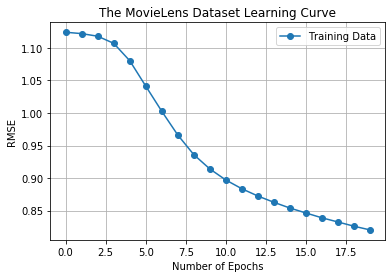

In [39]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

terminating gradient descent before con- vergence criteria are reached

## Q5

### (a)

In [0]:
eval_metrics = ['RMSE','P@K','R@K']

cv_rmse = CrossValidation(eval_metrics[0])
cv_patk = CrossValidation(eval_metrics[1])
cv_ratk = CrossValidation(eval_metrics[2])
#gather algorithm instances
algorithm_instances=[average_user_rating_recsys, popularity_recsys, user_cosine_recsys, item_cosine_recsys, pmf]

In [41]:
rmse_results = cv_rmse.run(algorithm_instances, num_users, num_items, k=5)
patk_results = cv_patk.run(algorithm_instances, num_users, num_items, k=5)
ratk_results = cv_ratk.run(algorithm_instances, num_users, num_items, k=5)

Processing algorithm useraverage


20000it [00:11, 1718.51it/s]
20000it [00:11, 1690.97it/s]
20000it [00:11, 1733.75it/s]
20000it [00:11, 1748.08it/s]
20000it [00:11, 1748.58it/s]


Processing algorithm popularity


20000it [00:11, 1694.88it/s]
20000it [00:11, 1736.18it/s]
20000it [00:11, 1727.79it/s]
20000it [00:11, 1740.68it/s]
20000it [00:11, 1742.13it/s]


Processing algorithm user-cosine


20000it [00:11, 1720.60it/s]
20000it [00:11, 1724.98it/s]
20000it [00:11, 1726.24it/s]
20000it [00:11, 1731.66it/s]
20000it [00:11, 1707.65it/s]


Processing algorithm item-cosine


20000it [00:11, 1716.46it/s]
20000it [00:11, 1674.34it/s]
20000it [00:11, 1729.81it/s]
20000it [00:11, 1733.65it/s]
20000it [00:11, 1748.74it/s]


Processing algorithm PMF


20000it [00:18, 1079.92it/s]
20000it [00:18, 1063.47it/s]
20000it [00:18, 1073.10it/s]
20000it [00:18, 1071.12it/s]
20000it [00:19, 1050.11it/s]


Processing algorithm useraverage


20000it [00:11, 1731.48it/s]
20000it [00:11, 1743.44it/s]
20000it [00:11, 1730.55it/s]
20000it [00:11, 1760.03it/s]
20000it [00:11, 1740.56it/s]


Processing algorithm popularity


20000it [00:11, 1753.78it/s]
20000it [00:11, 1729.67it/s]
20000it [00:11, 1740.46it/s]
20000it [00:11, 1729.37it/s]
20000it [00:11, 1718.93it/s]


Processing algorithm user-cosine


20000it [00:11, 1730.52it/s]
20000it [00:11, 1731.50it/s]
20000it [00:11, 1735.15it/s]
20000it [00:11, 1734.64it/s]
20000it [00:11, 1722.21it/s]


Processing algorithm item-cosine


20000it [00:11, 1736.06it/s]
20000it [00:11, 1735.37it/s]
20000it [00:11, 1715.85it/s]
20000it [00:11, 1718.00it/s]
20000it [00:11, 1731.89it/s]


Processing algorithm PMF


20000it [00:18, 1062.39it/s]
20000it [00:18, 1053.89it/s]
20000it [00:18, 1055.80it/s]
20000it [00:18, 1053.48it/s]
20000it [00:18, 1063.36it/s]


Processing algorithm useraverage


20000it [00:11, 1710.65it/s]
20000it [00:11, 1731.80it/s]
20000it [00:11, 1752.80it/s]
20000it [00:11, 1741.96it/s]
20000it [00:11, 1747.66it/s]


Processing algorithm popularity


20000it [00:11, 1719.78it/s]
20000it [00:11, 1752.65it/s]
20000it [00:11, 1732.86it/s]
20000it [00:11, 1749.34it/s]
20000it [00:11, 1756.80it/s]


Processing algorithm user-cosine


20000it [00:11, 1715.05it/s]
20000it [00:11, 1700.87it/s]
20000it [00:11, 1707.88it/s]
20000it [00:11, 1766.80it/s]
20000it [00:11, 1742.19it/s]


Processing algorithm item-cosine


20000it [00:11, 1737.08it/s]
20000it [00:11, 1729.41it/s]
20000it [00:11, 1747.87it/s]
20000it [00:11, 1747.21it/s]
20000it [00:11, 1737.16it/s]


Processing algorithm PMF


20000it [00:18, 1071.27it/s]
20000it [00:18, 1069.90it/s]
20000it [00:18, 1073.52it/s]
20000it [00:18, 1077.50it/s]
20000it [00:18, 1068.92it/s]


In [58]:
results=[rmse_results, patk_results, ratk_results] 
metric_names=['RMSE','P@K','R@k']
i=0
print('method\t\tMean\t\tCI') 
print("____________________________________________________________________") 
while i<3:
  result=results[i] 
  metric_name=metric_names[i]
  print('\t\tMetric: %s' %metric_name)
  i+=1
  #result is dictionary
  # k is the method name 
  for k,v in result.items(): 
    print('{:<8s}\t{:<10.10f}\t{}'.format(k, v[-3],(v[-2],v[-1])))
  print('')
# k=5

method		Mean		CI
____________________________________________________________________
		Metric: RMSE
useraverage	1.0437176562	(1.0289303496379316, 1.0585049626810734)
popularity	3.1590928910	(3.139292746995387, 3.1788930349826354)
user-cosine	1.0173541217	(1.009013080226148, 1.0256951630950135)
item-cosine	1.0200829001	(1.0068242686250732, 1.0333415315874226)
PMF     	0.9413331575	(0.9242915920883524, 0.9583747228899612)

		Metric: P@K
useraverage	0.4736373277	(0.3419993013451059, 0.6052753540101459)
popularity	0.5505832450	(0.40544114481568705, 0.6957253451100839)
user-cosine	0.5558430541	(0.40959849499983714, 0.7020876131655943)
item-cosine	0.5322163309	(0.3837005215009889, 0.6807321402169354)
PMF     	0.5575397667	(0.41044435295645854, 0.7046351804475735)

		Metric: R@k
useraverage	0.4413232050	(0.32931026359142457, 0.5533361464534351)
popularity	0.4840758879	(0.3671373629798323, 0.6010144127889052)
user-cosine	0.4862687236	(0.3694473610987218, 0.6030900860085656)
item-cosine	0.4749

In [49]:
# result.items()

dict_items([('useraverage', [[0.30505841002027845, 0.39554692074366876, 0.48030412192442223, 0.5045885853815734, 0.5211179870422066], 0.44132320502242983, 0.32931026359142457, 0.5533361464534351]), ('popularity', [[0.3466588624187514, 0.4274468698270901, 0.5269205125667804, 0.5518738761026849, 0.5674793185065369], 0.4840758878843688, 0.3671373629798323, 0.6010144127889052]), ('user-cosine', [[0.34778041993806913, 0.4314035774468209, 0.5293633772333985, 0.5553818201403046, 0.5674144230096255], 0.4862687235536437, 0.3694473610987218, 0.6030900860085656]), ('item-cosine', [[0.3277711938444533, 0.4237782250680911, 0.5191391022223312, 0.5448659224612776, 0.5593011306991799], 0.4749711148590666, 0.35357317503649865, 0.5963690546816346]), ('PMF', [[0.3432950574667835, 0.4337344319133528, 0.5287626620906087, 0.552299699025838, 0.5677906646976882], 0.4851765030388543, 0.36737044908126154, 0.6029825569964471])])

### (b)

RMSE cannot evaluate popularity based metric because popularity in the question is interpreted as percentage. However, it makes no sense to find the mean squared error of percentage since the RMSE will be very large.


### (c)

For RMSE, the best algorithm is PMF. PMF is an optimizing algorithm to minimize the mean squared error and that makes sure PMF would have a good performance. For P@K and R@K, user-cosine and PMF both perform well while user-cosine might be a little better. The reason might be user-cosine cares more about personal preference, and we have more items per user, which give the more accuracy when predict by user user similarity. Overall, PMF performs better.


### (d)

Good performance on RMSE does may imply good performance on ranking metrics because this means there are fewer errors. But, good performance on ranking metrics does not necessarily mean good performance on RMSE. RMSE does not require the order of ranking.

## Q6

### (a)

In [59]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')
pd.options.display.max_rows=1000
moviesDF

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [60]:
movies_list = ['Apollo 13 (1995)', 'Lion King, The (1994)', 'Dances with Wolves (1990)']
train_matrix = dataPreprocessor(rating_df, num_users, num_items).T
#using item item cosine similarity
ii_similarity = SimBasedRecSys.cosine(train_matrix)
# construct item-item similarity matrix
movie_names = moviesDF.movieTitle.values
movieSimDF = pd.DataFrame(data=ii_similarity,columns=movie_names,index=movie_names)
for movie in movies_list:
  print('Top 5 most similar movies to {0} are:'.format(movie))
  print(movieSimDF[movie].nlargest(6)[1:])
  print('\n')


Top 5 most similar movies to Apollo 13 (1995) are:
Forrest Gump (1994)                  0.737262
E.T. the Extra-Terrestrial (1982)    0.724621
Raiders of the Lost Ark (1981)       0.699759
Back to the Future (1985)            0.690253
Jurassic Park (1993)                 0.665404
Name: Apollo 13 (1995), dtype: float64


Top 5 most similar movies to Lion King, The (1994) are:
Aladdin (1992)                       0.753162
Beauty and the Beast (1991)          0.687876
Forrest Gump (1994)                  0.681586
Jurassic Park (1993)                 0.661856
E.T. the Extra-Terrestrial (1982)    0.646782
Name: Lion King, The (1994), dtype: float64


Top 5 most similar movies to Dances with Wolves (1990) are:
Forrest Gump (1994)                  0.718935
E.T. the Extra-Terrestrial (1982)    0.692333
When Harry Met Sally... (1989)       0.668803
Raiders of the Lost Ark (1981)       0.659907
Back to the Future (1985)            0.658584
Name: Dances with Wolves (1990), dtype: float64




### (b)

We use the item-item similarity to show the ranked similarity of each movie. For the first movie "Apollo 13", it is an aventure, drama, history  film and all top4 are aventure, and also the top 1 Forrest Gump has the same actor as the lead.

"Lion King" is an animation movie made by Disney company. Therefore, we can say the top 2 also is about disney stories.

For the last movie "Dance with Wolves", it has war plot, and it is an adventure, romantic and western land.  For the recommended movies, they are all either adventure or romantic drama. Overall, the item-item similarity works pretty well.

## Q7

### (a)

Text(0, 0.5, 'Number of users')

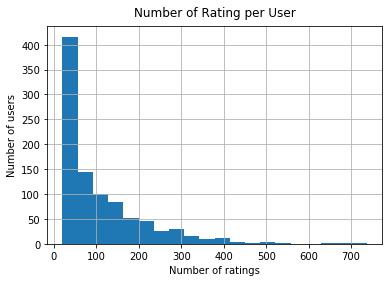

In [115]:
rating_per_userDF = rating_df.groupby('userID').count().reset_index()
rating_per_userDF.drop(columns=['itemID','timestamp'],axis=1,inplace=True)

rating_per_userDF['rating'].hist(bins=20)
plt.title('Number of Rating per User',pad=10)
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')

In [0]:
threshold=100

In [0]:
ratingDF_aboveT = rating_df[rating_df['userID'].isin(rating_per_userDF[rating_per_userDF['rating']>=threshold]['userID'].tolist())]
ratingDF_belowT= rating_df[rating_df['userID'].isin(rating_per_userDF[rating_per_userDF['rating']<threshold]['userID'].tolist())]

In [104]:
user_cosine_recsys_aboveT = SimBasedRecSys('user','cosine')
user_cosine_recsys_aboveT.predict_all(ratingDF_aboveT, num_users, num_items)
user_cosine_recsys_aboveT.getModel()
uuDF_aboveT = user_cosine_recsys_aboveT.evaluate_test(ratingDF_aboveT,copy=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide
74522it [01:02, 1183.15it/s]


In [105]:
item_cosine_recsys_aboveT = SimBasedRecSys('item','cosine')
item_cosine_recsys_aboveT.predict_all(ratingDF_aboveT, num_users, num_items)
item_cosine_recsys_aboveT.getModel()
iiDF_aboveT = item_cosine_recsys_aboveT.evaluate_test(ratingDF_aboveT,copy=True)

74522it [01:04, 1164.36it/s]


In [106]:
user_cosine_recsys_belowT = SimBasedRecSys('user','cosine')
user_cosine_recsys_belowT.predict_all(ratingDF_belowT, num_users, num_items)

uuDF_belowT = user_cosine_recsys_belowT.evaluate_test(ratingDF_belowT,copy=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide
25478it [00:15, 1642.22it/s]


In [107]:
item_cosine_recsys_belowT = SimBasedRecSys('item','cosine')
item_cosine_recsys_belowT.predict_all(ratingDF_belowT, num_users, num_items)
iiDF_belowT = item_cosine_recsys_belowT.evaluate_test(ratingDF_belowT,copy=True)

25478it [00:15, 1649.03it/s]


In [108]:
df_list = [uuDF_aboveT, uuDF_belowT, iiDF_aboveT, iiDF_belowT]
ui_list = ['user-user','user_user','item-item','item-item']
th_list = ['below threshold', 'above threshold']*2


for i, df in enumerate(df_list):
    pred = df.iloc[:,-1]
    rating = df.loc[:]['rating']
    rsme = sqrt(mean_squared_error(pred, rating))
    print('The RSME of {0} based method {1} is: {2} \n'.format(ui_list[i], th_list[i], rsme))

The RSME of user-user based method below threshold is: 0.9481767606298663 

The RSME of user_user based method above threshold is: 0.8901312664100373 

The RSME of item-item based method below threshold is: 0.9946094755385316 

The RSME of item-item based method above threshold is: 0.8942223431150697 



For both method, the subset below the threshold performs better. It happens because with the more ratings per person, the more the model can learn from and thus fewer errors.

# Validation

In [0]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [0]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [0]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [0]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validatePopularityRecSys()

### User Average Based Recommendation

In [0]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateUserAverRecSys()

## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [0]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [0]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [0]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [0]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [0]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [128]:
validateUUSimBasedRecSys()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide


### Item-Item Similarity Based Recommendation System

In [0]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateIISimBasedRecSys()

### Probabilistic Matrix Factorization Recommendation System

In [0]:
def validatePMFRecSys(validation_df=validation_df):
    try:
        pmf = PMFRecSys()
        pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 1, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
        pmf.predict_all(rating_df, ROW_NUM, COL_NUM)
    except:
        print("Got error when instantiate PMFRecSys")
        return
    
    try:
        pmf.predict_all(validation_df, ROW_NUM, COL_NUM)
        W_item, W_user = pmf.w_Item, pmf.w_User
        assert(W_item.shape == (COL_NUM+1, 10) and W_user.shape == (ROW_NUM+1, 10)),\
        "Shape of w_Item and W_User doesn't match predefined shape"
    except Exception as e:
        print(e)

In [0]:
validatePMFRecSys(validation_df=validation_df)